In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import sys,os
import json
import random
import altair as alt

from scipy import stats
from pymongo import MongoClient
from tqdm import tqdm

In [5]:
%matplotlib inline
sns.set(style="darkgrid")

In [6]:
client = MongoClient('localhost', 27017)
db = client.TFE
collection = db.news_cleaned

In [7]:
res = collection.aggregate([
    {
        '$group': {
                '_id' : {'type' : '$type'},
                'newsCount' : {'$sum' : 1}
            }
        }])

In [8]:
types = []
count = []
for r in res:
    types.append(r['_id']['type'])
    count.append(r['newsCount'])

In [9]:
data = pd.DataFrame({'x' : types, 'y' : count})

/home/simon/anaconda3/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


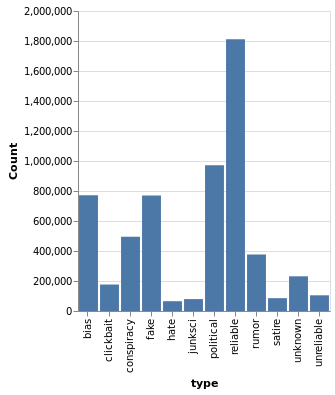

In [10]:
alt.Chart(data).mark_bar().encode(
    x = alt.X('x', axis=alt.Axis(title="type")),
    y = alt.Y('y', axis=alt.Axis(title="Count"))
)

In [25]:
avgSentenceLength = {}
for t in types:
    data = collection.find({'type' : t}, {'avgSentenceLength' : True, '_id' : False})
    data = [x['avgSentenceLength'] for x in data]
    avgSentenceLength[t] = data

In [23]:
data = pd.DataFrame(columns=['l', 'q1', 'q2', 'q3', 'h', 'type'])

In [24]:
p = []
for t in types:
    percentile = np.percentile(avgSentenceLength[t], [25, 50, 75], interpolation='linear')
    p.append({'l': percentile[0] - (percentile[1] - percentile[0]) * 1.5, 'q1' : percentile[0], 'q2' : percentile[1], 'q3' : percentile[2], 'h' : percentile[2] + (percentile[2] - percentile[1]) * 1.5,  'type' : t})

In [25]:
data = data.append(p)

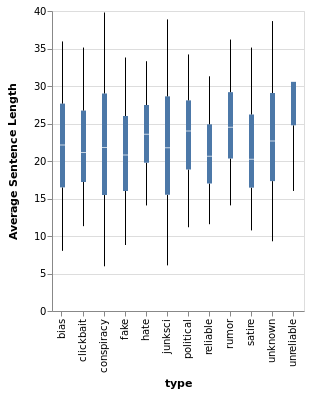

In [26]:
base = alt.Chart(data)

lower_plot = base.mark_rule().encode(
    y=alt.Y('l', axis=alt.Axis(title="Average Sentence Length")),
    y2='q1',
    x='type'
)

middle_plot = base.mark_bar(size=5.0).encode(
    y='q1',
    y2='q3',
    x='type'
)
upper_plot = base.mark_rule().encode(
    y='h',
    y2='q3',
    x='type'
)

middle_tick = base.mark_tick(
    color='white',
    size=5.0
).encode(
    y='q2',
    x='type',
)

lower_plot + middle_plot + upper_plot + middle_tick


In [62]:
numSentences = {}
for t in types:
    data = collection.find({'type' : t}, {'numSentences' : True, '_id' : False})
    data = [x['numSentences'] for x in data]
    numSentences[t] = data
    
p = []
for t in types:
    percentile = np.percentile(numSentences[t], [25, 50, 75], interpolation='linear')
    p.append({'l': percentile[0] - (percentile[1] - percentile[0]) * 1.5, 'q1' : percentile[0], 'q2' : percentile[1], 'q3' : percentile[2], 'h' : percentile[2] + (percentile[2] - percentile[1]) * 1.5,  'type' : t})

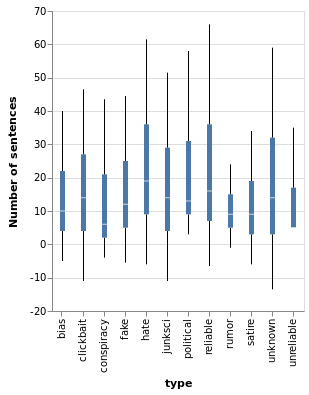

In [89]:
data = pd.DataFrame(columns=['l', 'q1', 'q2', 'q3', 'h', 'type'])
data = data.append(p)

base = alt.Chart(data)

lower_plot = base.mark_rule().encode(
    y=alt.Y('l', axis=alt.Axis(title="Number of sentences")),
    y2='q1',
    x='type'
)

middle_plot = base.mark_bar(size=5.0).encode(
    y='q1',
    y2='q3',
    x='type'
)
upper_plot = base.mark_rule().encode(
    y='h',
    y2='q3',
    x='type'
)

middle_tick = base.mark_tick(
    color='white',
    size=5.0
).encode(
    y='q2',
    x='type',
)

lower_plot + middle_plot + upper_plot + middle_tick

In [11]:
domain = []
count = []
for t in types:
    domain = []
    count = []
    for res in collection.aggregate([
        {'$match': {'type' : t}},
        {
            '$group': {
                    '_id' : {'domain' : '$domain'},
                    'newsCount' : {'$sum' : 1}
                }
        }
            ]):
        domain.append(res['_id']['domain'])
        count.append(res['newsCount'])
    data = pd.DataFrame({'x' : domain, 'y' : count})
    chart = alt.Chart(data).mark_bar().encode(
        x = alt.X('x', axis=alt.Axis(title="domains")),
        y = alt.Y('y', axis=alt.Axis(title="Count")))
    chart.save('out/'+t+'.svg')

/home/simon/anaconda3/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])
/home/simon/anaconda3/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])
/home/simon/anaconda3/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])
/home/simon/anaconda3/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=

In [76]:
metadata = db.metadata

In [81]:
for i in range(0, len(domains)):
    metadata.insert_one({'_id' : i, 'domain' : domains[i], 'metadata' : {'count' : {'total' : count[i]}}})

In [88]:
# Looking if some domains have multiple kind of news
for res in collection.aggregate([
    {
        '$group': {
                '_id' : {'domain' : '$domain', 'type' : '$type'},
                'newsCount' : {'$sum' : 1}
            }
    },
    {
        '$group' : 
        {
            '_id' : '$_id.domain',
            'meta' : 
            {
                '$push' : 
                {
                    'type' : '$_id.type',
                    'count' : '$newsCount'
                }
            }
        }
     }
        ]):
    if len(res['meta']) > 1:
        print(res)